# CSC420 A2 Part II

## **Task II**

I acknowledge that I used the code from https://medium.com/@ankitvashisht12/classifying-dog-breed-using-pytorch-abc9f3c5128a as my starter code.

Imports


In [1]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
%matplotlib inline

Unzip

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/CSC420/A2/DBIsubset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')


Mounted at /content/drive


Dataset Exploration


In [3]:
dataset = ImageFolder('/content/DBIsubset')

In [ ]:
len(dataset)

In [ ]:
len(dataset.classes)

In [ ]:
breeds = []

def rename(name):
    return ' '.join(' '.join(name.split('-')[1:]).split('_'))

for n in dataset.classes:
    breeds.append(rename(n))

Creating training, validation and testing dataset


In [ ]:
random_seed = 420
torch.manual_seed(random_seed);

In [ ]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size


train_size, val_size, test_size

(408, 45, 193)

In [ ]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(408, 45, 193)

labrador_retriever
<class 'PIL.Image.Image'>


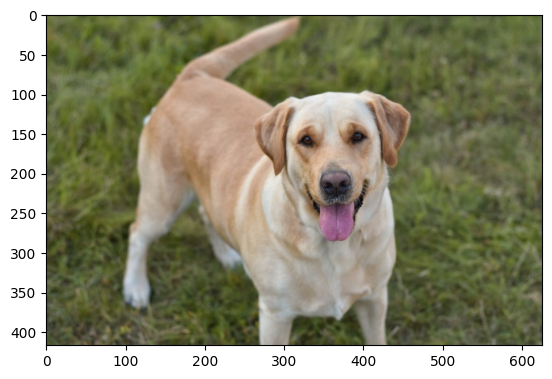

In [ ]:
img, label = train_ds[6]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))

Creating Custom Dataset


In [ ]:
class DogBreedDataset(Dataset):

    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)
            return img, label

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
#    transforms.Resize((224, 224)),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)

])


val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

In [ ]:
train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)

4


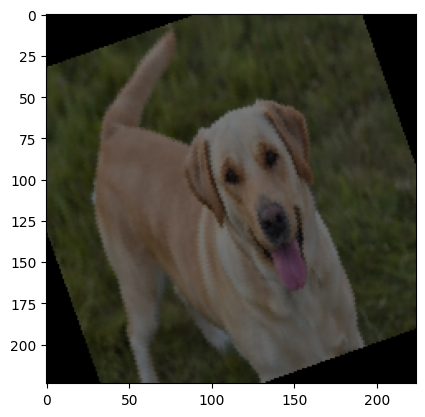

In [ ]:
img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

In [ ]:
batch_size =64

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break

In [ ]:
show_batch(train_dl)

Network Architecture


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.cross_entropy(out, targets) # cross entropy
        acc = accuracy(out, targets)
        # return acc
        return {'train_loss': loss, 'train_acc': acc}

    # testing step
    def testing_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.cross_entropy(out, targets) # cross entropy
        acc = accuracy(out, targets)
        return {'test_loss': loss.detach(), 'test_acc': acc.detach()}

    # testing epoch end
    def testing_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'test_loss':epoch_loss.item(), 'test_acc':epoch_acc.item()}

    # print result end epoch
    def epoch_end(self, epoch, result):
        # print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))
        print("Epoch [{}] : train_acc: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_acc"], result["test_acc"]))


In [ ]:
class DogBreedClassificationCNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv2d(3, 16, 3),  # 1st convolutional layer with 16 filters of size 3x3
            nn.BatchNorm2d(16),   # Batch normalization
            nn.ReLU(),             # ReLU activation

            nn.Conv2d(16, 16, 3), # 2nd convolutional layer with 16 filters of size 3x3
            nn.MaxPool2d(2, 2),    # Max pooling with size 2x2

            nn.Conv2d(16, 8, 3),  # 3rd convolutional layer with 8 filters of size 3x3
            nn.BatchNorm2d(8),    # Batch normalization
            nn.ReLU(),             # ReLU activation

            nn.Conv2d(8, 8, 3),   # 4th convolutional layer with 8 filters of size 3x3
            nn.MaxPool2d(2, 2),    # Max pooling with size 2x2

            nn.Flatten(),          # Flattening the 3D tensor to 1D

            nn.Dropout(0.5),       # Dropout layer with p=0.5
            # nn.Linear(8 * 6 * 6, 32), # Fully connected layer (assuming input size 32x32; adjust dimensions if needed)
            nn.Linear(8 * 53 * 53, 32),
            nn.ReLU(),             # ReLU activation

            nn.Dropout(0.5),       # Another dropout layer with p=0.5
            nn.Linear(32, 7),      # Output layer for 7 classes
            nn.Softmax(dim=1)      # Softmax activation
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = DogBreedClassificationCNN()
model

Training

In [ ]:
# check the model
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = model(imgs)                                  # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        break

In [ ]:
try_batch(train_dl)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_one_cycle(epochs, max_lr, model, train_loader, test_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):

        # Training phase
        model.train()
        # train_losses = []
        train_accs = []  # to store training accuracies
        lrs = []
        for batch in tqdm(train_loader):
            # print(f"Debug - batch: {batch}")  # Debug line 1
            train_result = model.training_step(batch)
            # print(f"Debug - result: {result}")  # Debug line 2
            # print(f"Debug - train_loss: {result['train_loss']}, train_acc: {result['train_acc']}")  # Debug line
            # train_losses.append(result['train_loss'])
            train_accs.append(train_result['train_acc'])

            # calculates gradients
            train_result['train_loss'].backward()

            # check gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            # perform gradient descent and modifies the weights
            optimizer.step()

            # reset the gradients
            optimizer.zero_grad()

            # record and update lr
            lrs.append(get_lr(optimizer))

            # modifies the lr value
            sched.step()

        # Validation phase
        result = evaluate(model, test_loader)
        # result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()
        # train_losses.append(result['train_loss'].item())  # Updated
        # train_accs.append(result['train_acc'].item())  # Updated
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)


    return history



@torch.no_grad()
def evaluate(model, test_loader):
    model.eval()
    outputs = [model.testing_step(batch) for batch in test_loader]
    return model.testing_epoch_end(outputs)

In [ ]:
evaluate(model, test_dl)                 # change model object here

In [ ]:
# set hyperparams
num_epochs = 10
opt_func = torch.optim.SGD

max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4

In [ ]:
history = fit_one_cycle(num_epochs, max_lr, model, train_dl, test_dl, weight_decay, grad_clip, opt_func)

Plotting history

In [ ]:
history[0].keys()

Loss v/s Epochs plot


In [ ]:
train_acc = [x['train_acc'] for x in history]
val_acc = [x['test_acc'] for x in history]
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Testing acc')
plt.title('Training and Testing accuracy with dropout')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('task2_1.png')
plt.show()

In [ ]:
# CNN model without dropout

class DogBreedClassificationCNN_without_dropout(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv2d(3, 16, 3),  # 1st convolutional layer with 16 filters of size 3x3
            nn.BatchNorm2d(16),   # Batch normalization
            nn.ReLU(),             # ReLU activation

            nn.Conv2d(16, 16, 3), # 2nd convolutional layer with 16 filters of size 3x3
            nn.MaxPool2d(2, 2),    # Max pooling with size 2x2

            nn.Conv2d(16, 8, 3),  # 3rd convolutional layer with 8 filters of size 3x3
            nn.BatchNorm2d(8),    # Batch normalization
            nn.ReLU(),             # ReLU activation

            nn.Conv2d(8, 8, 3),   # 4th convolutional layer with 8 filters of size 3x3
            nn.MaxPool2d(2, 2),    # Max pooling with size 2x2

            nn.Flatten(),          # Flattening the 3D tensor to 1D

            # nn.Linear(8 * 6 * 6, 32), # Fully connected layer (assuming input size 32x32; adjust dimensions if needed)
            nn.Linear(8 * 53 * 53, 32),
            nn.ReLU(),             # ReLU activation

            nn.Linear(32, 7),      # Output layer for 7 classes
            nn.Softmax(dim=1)      # Softmax activation
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model_without = DogBreedClassificationCNN_without_dropout()

In [ ]:
try_batch(train_dl)

In [ ]:
evaluate(model_without, test_dl)                 # change model object here

In [ ]:
# set hyperparams
num_epochs = 10
opt_func = torch.optim.SGD

max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4

In [ ]:
history_without = fit_one_cycle(num_epochs, max_lr, model_without, train_dl, test_dl, weight_decay, grad_clip, opt_func)

In [ ]:
history_without[0].keys()

dict_keys(['test_loss', 'test_acc', 'train_acc', 'lrs'])

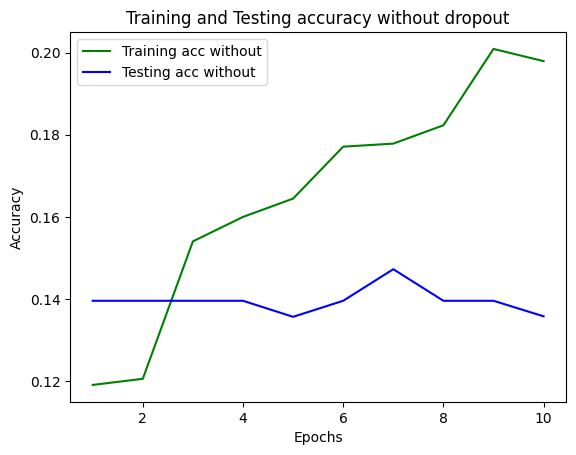

In [ ]:
train_acc_without = [x['train_acc'] for x in history_without]
val_acc_without = [x['test_acc'] for x in history_without]
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc_without, 'g', label='Training acc without')
plt.plot(epochs, val_acc_without, 'b', label='Testing acc without')
plt.title('Training and Testing accuracy without dropout')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('task2_2.png')
plt.show()

Task III (a)

In [ ]:
class CustomResNet(ImageClassificationBase):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        # Initialize the resnet18 model
        self.network = resnet18(pretrained=False)
        # Modify the output layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
# Import ResNet-18
from torchvision.models import resnet18

# Modify the output layer
num_classes = 7
# resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)
custom_resnet_model = CustomResNet(num_classes=num_classes)

# Train the model
history_resnet = fit_one_cycle(num_epochs, max_lr, custom_resnet_model, train_dl, test_dl, weight_decay, grad_clip, opt_func)

In [ ]:
# Plotting the accuracy for ResNet model
train_acc_resnet = [x['train_acc'] for x in history_resnet]
val_acc_resnet = [x['test_acc'] for x in history_resnet]

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, 'g', label='Training acc (Custom CNN)')
plt.plot(epochs, val_acc, 'b', label='Testing acc (Custom CNN)')
plt.plot(epochs, train_acc_resnet, 'r--', label='Training acc (ResNet-18)')
plt.plot(epochs, val_acc_resnet, 'm--', label='Testing acc (ResNet-18)')
plt.title('Comparison of Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('task3_a.png')
plt.show()

Task III (b)

In [4]:
with zipfile.ZipFile('/content/drive/MyDrive/CSC420/A2/SDDsubset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [5]:
dataset_SDD = ImageFolder('/content/SDDsubset')

In [ ]:
len(dataset_SDD)

In [ ]:
len(dataset_SDD.classes)

In [ ]:
random_seed = 420
torch.manual_seed(random_seed);

In [ ]:
sdd_dataset = DogBreedDataset(dataset_SDD, transform=test_transform)
sdd_dl = DataLoader(sdd_dataset, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
sdd_results = evaluate(custom_resnet_model, sdd_dl)
sdd_accuracy = sdd_results['test_acc']

In [ ]:
print(sdd_accuracy)

In [ ]:
dbi_accuracy = history_resnet[-1]['test_acc']
print(dbi_accuracy)

Task IV

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_one_cycle(epochs, max_lr, model, train_loader, test_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):

        # Training phase
        model.train()
        # train_losses = []
        train_accs = []  # to store training accuracies
        lrs = []
        for batch in tqdm(train_loader):
            # print(f"Debug - batch: {batch}")  # Debug line 1
            train_result = model.training_step(batch)
            # print(f"Debug - result: {result}")  # Debug line 2
            # print(f"Debug - train_loss: {result['train_loss']}, train_acc: {result['train_acc']}")  # Debug line
            # train_losses.append(result['train_loss'])
            train_accs.append(train_result['train_acc'])

            # calculates gradients
            train_result['train_loss'].backward()

            # check gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            # perform gradient descent and modifies the weights
            optimizer.step()

            # reset the gradients
            optimizer.zero_grad()

            # record and update lr
            lrs.append(get_lr(optimizer))

            # modifies the lr value
            sched.step()

        # Validation phase
        result = evaluate(model, test_loader)
        # result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accs).mean().item()
        # train_losses.append(result['train_loss'].item())  # Updated
        # train_accs.append(result['train_acc'].item())  # Updated
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)


    return history



@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
# Import necessary modules
from torchvision.models import resnet18

class CustomResNet18(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet18, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        in_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(in_features, num_classes)

    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.cross_entropy(out, targets)
        acc = accuracy(out, targets)
        return {'train_loss': loss, 'train_acc': acc}

    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.cross_entropy(out, targets)
        acc = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def test_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.cross_entropy(out, targets)
        acc = accuracy(out, targets)
        return {'test_loss': loss.detach(), 'test_acc': acc.detach()}

    def test_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}

    # print result end epoch
    def epoch_end(self, epoch, result):
        # print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))
        print("Epoch [{}] : train_acc: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_acc"], result["val_acc"]))

    def forward(self, xb):
        return self.resnet18(xb)

In [ ]:
# Initialize pre-trained ResNet18 model
resnet18_model = CustomResNet18(num_classes=7)

# Fine-tuning the ResNet18 model
num_epochs = 10
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.SGD

In [ ]:
history_resnet18 = fit_one_cycle(num_epochs, max_lr, resnet18_model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

In [ ]:
@torch.no_grad()
def evaluate_test(model, test_loader):
    model.eval()
    outputs = [model.test_step(batch) for batch in test_loader]
    return model.test_epoch_end(outputs)

# Evaluate on the DBI test set
dbi_results_resnet18 = evaluate_test(resnet18_model, test_dl)
dbi_accuracy_resnet18 = dbi_results_resnet18['test_acc']
print(dbi_accuracy_resnet18)

0.9610576629638672


In [ ]:
sdd_results_resnet18 = evaluate_test(resnet18_model, sdd_dl)
sdd_accuracy_resnet18 = sdd_results_resnet18['test_acc']

In [ ]:
print(sdd_accuracy_resnet18)

0.8214505910873413


In [ ]:
print(dbi_accuracy_resnet18)

0.9610576629638672


In [ ]:
# Import the necessary modules
from torchvision.models import resnet34

# Load the pre-trained ResNet34 model
resnet34_model = resnet34(pretrained=True)

# Modify the last layer to match the number of classes in the DBI dataset
num_classes = 7
resnet34_model.fc = nn.Linear(resnet34_model.fc.in_features, num_classes)

# Define a custom ResNet34 class
class CustomResNet34(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet34, self).__init__()
        self.resnet34 = resnet34(pretrained=True)
        in_features = self.resnet34.fc.in_features
        self.resnet34.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet34(x)

    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.cross_entropy(out, targets)
        acc = accuracy(out, targets)
        return {'train_loss': loss, 'train_acc': acc}

    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.cross_entropy(out, targets)
        acc = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def test_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.cross_entropy(out, targets)
        acc = accuracy(out, targets)
        return {'test_loss': loss.detach(), 'test_acc': acc.detach()}

    def test_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}

    # print result end epoch
    def epoch_end(self, epoch, result):
        # print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))
        print("Epoch [{}] : train_acc: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_acc"], result["val_acc"]))

# Initialize the custom ResNet34 model
custom_resnet34_model = CustomResNet34(num_classes=num_classes)

# Training parameters
num_epochs = 10
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.SGD

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Train the model
history_resnet34 = fit_one_cycle(num_epochs, max_lr, custom_resnet34_model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0] : train_acc: 0.1749, val_acc: 0.2667


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1] : train_acc: 0.2626, val_acc: 0.5333


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2] : train_acc: 0.6607, val_acc: 0.8000


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3] : train_acc: 0.8921, val_acc: 0.9778


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4] : train_acc: 0.9182, val_acc: 1.0000


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5] : train_acc: 0.9412, val_acc: 1.0000


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6] : train_acc: 0.9449, val_acc: 0.9778


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7] : train_acc: 0.9576, val_acc: 1.0000


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8] : train_acc: 0.9665, val_acc: 1.0000


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9] : train_acc: 0.9635, val_acc: 1.0000


In [ ]:
# Evaluate on the DBI test set
dbi_results_resnet34 = evaluate_test(custom_resnet34_model, test_dl)
dbi_accuracy_resnet34 = dbi_results_resnet34['test_acc']
print(dbi_accuracy_resnet34)

0.9844951629638672


In [ ]:
# Evaluate on the SDD data set
sdd_results_resnet34 = evaluate_test(custom_resnet34_model, sdd_dl)
sdd_accuracy_resnet34 = sdd_results_resnet34['test_acc']

In [ ]:
print(sdd_accuracy_resnet34)

0.8595293164253235


In [ ]:
print(dbi_accuracy_resnet34)

0.9844951629638672


In [ ]:
# Import necessary modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models

class CustomResNeXt50(nn.Module):
    def __init__(self, num_classes=7):
        super(CustomResNeXt50, self).__init__()
        self.resnext50 = models.resnext50_32x4d(pretrained=True)
        in_features = self.resnext50.fc.in_features
        self.resnext50.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnext50(x)

In [ ]:
# Assuming smaller batch size for DataLoader
train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=64, shuffle=False)
sdd_dl = DataLoader(sdd_dataset, batch_size=64, shuffle=False)

In [ ]:
# Initialize the custom ResNeXt50 model
custom_resnext50_model = CustomResNeXt50(num_classes=7)
optimizer_resnext50 = optim.Adam(custom_resnext50_model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 177MB/s]


In [ ]:
from tqdm import tqdm

# Outer loop for epochs with its own progress bar
for epoch in tqdm(range(10), desc="Epochs"):
    custom_resnext50_model.train()

    # Inner loop for mini-batches with its own progress bar
    for i, data in tqdm(enumerate(train_dl), desc="Mini-batches", leave=False):
        inputs, labels = data
        optimizer_resnext50.zero_grad()
        outputs = custom_resnext50_model(inputs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer_resnext50.step()

In [ ]:
# Evaluation function
def evaluate_test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.cross_entropy(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return {'test_loss': test_loss, 'test_acc': accuracy}

In [ ]:
# Evaluate on the DBI test set
dbi_results_resnext50 = evaluate_test(custom_resnext50_model, test_dl)
dbi_accuracy_resnext50 = dbi_results_resnext50['test_acc']
print(dbi_accuracy_resnext50)

# Evaluate on the SDD data set
sdd_results_resnext50 = evaluate_test(custom_resnext50_model, sdd_dl)
sdd_accuracy_resnext50 = sdd_results_resnext50['test_acc']
print(sdd_accuracy_resnext50)

52.33160621761658
40.957015409570154


In [ ]:
print(sdd_accuracy_resnext50)

40.957015409570154


In [ ]:
print(dbi_accuracy_resnext50)

52.33160621761658


In [ ]:
!pip install timm
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

In [ ]:
# Define a custom class for SwinTransformer (tiny)
class CustomSwinTransformerTiny(nn.Module):
    def __init__(self, num_classes):
        super(CustomSwinTransformerTiny, self).__init__()
        self.swin_tiny = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True)
        self.num_classes = num_classes
        in_features = self.swin_tiny.head.in_features
        self.swin_tiny.head = nn.Linear(in_features, self.num_classes)

    def forward(self, x):
        x = self.swin_tiny(x)  # Output shape: [batch_size, 7, 7, 7]
        x = x.mean(dim=[2, 3])  # Take the mean along the spatial dimensions
        return x

# Initialize the custom Swin Transformer model
num_classes = 7
custom_swin_tiny_model = CustomSwinTransformerTiny(num_classes=num_classes)

# Optimizer
optimizer_swin_tiny = torch.optim.Adam(custom_swin_tiny_model.parameters(), lr=0.001)

In [ ]:
# Training loop
for epoch in tqdm(range(10)):  # 10 epochs
    custom_swin_tiny_model.train()
    for i, data in enumerate(train_dl, 0):
        inputs, labels = data
        # print(f"Debug - inputs shape: {inputs.shape}, labels shape: {labels.shape}")  # Debug line
        optimizer_swin_tiny.zero_grad()
        outputs = custom_swin_tiny_model(inputs)
        # print(f"Outputs shape: {outputs.shape}, Labels shape: {labels.shape}")
        # print(f"Debug - outputs shape: {outputs.shape}")  # Debug line

        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer_swin_tiny.step()

100%|██████████| 10/10 [10:31<00:00, 63.20s/it]


In [ ]:
# Assuming evaluate_test is a function that evaluates the model
dbi_results_swin_tiny = evaluate_test(custom_swin_tiny_model, test_dl)
dbi_accuracy_swin_tiny = dbi_results_swin_tiny['test_acc']
print(dbi_accuracy_swin_tiny)

# Evaluate on the SDD dataset
sdd_results_swin_tiny = evaluate_test(custom_swin_tiny_model, sdd_dl)
sdd_accuracy_swin_tiny = sdd_results_swin_tiny['test_acc']
print(sdd_accuracy_swin_tiny)

23.316062176165804
17.59935117599351


In [ ]:
print(sdd_accuracy_swin_tiny)

17.59935117599351


In [ ]:
print(dbi_accuracy_swin_tiny)

23.316062176165804


In [ ]:
from torchvision import models

class CustomMobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super(CustomMobileNetV2, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        in_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.mobilenet(x)

# Initialize the custom MobileNetV2 model
num_classes = 7
custom_mobilenet_model = CustomMobileNetV2(num_classes=num_classes)

# Optimizer
optimizer_mobilenet = torch.optim.Adam(custom_mobilenet_model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 88.6MB/s]


In [ ]:
# Training loop
for epoch in tqdm(range(10)):  # 10 epochs
    custom_mobilenet_model.train()
    for i, data in enumerate(train_dl, 0):
        inputs, labels = data
        optimizer_mobilenet.zero_grad()
        outputs = custom_mobilenet_model(inputs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer_mobilenet.step()

100%|██████████| 10/10 [04:49<00:00, 28.96s/it]


In [ ]:
dbi_results_mobilenet = evaluate_test(custom_mobilenet_model, test_dl)
dbi_accuracy_mobilenet = dbi_results_mobilenet['test_acc']
print(dbi_accuracy_mobilenet)

sdd_results_mobilenet = evaluate_test(custom_mobilenet_model, sdd_dl)
sdd_accuracy_mobilenet = sdd_results_mobilenet['test_acc']
print(sdd_accuracy_mobilenet)

90.67357512953367
74.69586374695864


In [ ]:
print(sdd_accuracy_mobilenet)

74.69586374695864


In [ ]:
print(dbi_accuracy_mobilenet)

90.67357512953367


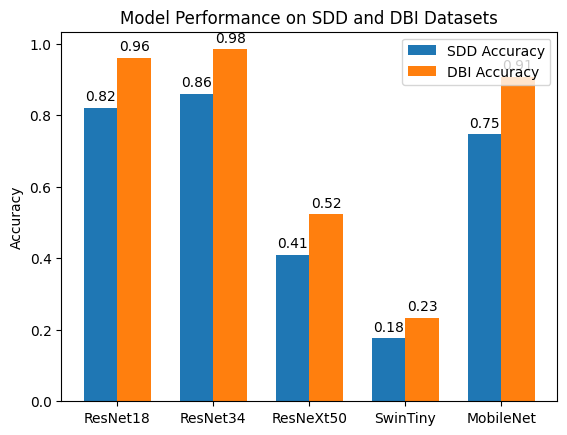

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['ResNet18', 'ResNet34', 'ResNeXt50', 'SwinTiny', 'MobileNet']
sdd_accuracies = [0.821, 0.860, 0.410, 0.176, 0.747]
dbi_accuracies = [0.961, 0.984, 0.523, 0.233, 0.907]

# Create a bar plot for the SDD and DBI accuracies
x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, sdd_accuracies, width, label='SDD Accuracy')
rects2 = ax.bar(x + width/2, dbi_accuracies, width, label='DBI Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance on SDD and DBI Datasets')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Label with percentage
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.savefig('task4_plt.png')
plt.show()

Task V

In [7]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

def split_and_combine_datasets(dbi_path, sdd_path, train_ratio=0.8):
    # Directories for combined datasets
    combined_train = 'combined_dataset/train'
    combined_test = 'combined_dataset/test'

    # Create these directories
    os.makedirs(f'{combined_train}/DBI', exist_ok=True)
    os.makedirs(f'{combined_train}/SDD', exist_ok=True)
    os.makedirs(f'{combined_test}/DBI', exist_ok=True)
    os.makedirs(f'{combined_test}/SDD', exist_ok=True)

    # Function to copy files for a dataset (DBI or SDD)
    def process_dataset(dataset_path, label):
        for breed_folder in os.listdir(dataset_path):
            breed_path = os.path.join(dataset_path, breed_folder)
            if os.path.isdir(breed_path):
                all_files = os.listdir(breed_path)
                random.shuffle(all_files)
                train_files, test_files = train_test_split(all_files, test_size=1-train_ratio)

                for file in train_files:
                    src_path = os.path.join(breed_path, file)
                    dest_path = os.path.join(combined_train, label, f"{breed_folder}_{file}")
                    shutil.copy(src_path, dest_path)

                for file in test_files:
                    src_path = os.path.join(breed_path, file)
                    dest_path = os.path.join(combined_test, label, f"{breed_folder}_{file}")
                    shutil.copy(src_path, dest_path)

    # Process each dataset
    process_dataset(dbi_path, 'DBI')
    process_dataset(sdd_path, 'SDD')

In [8]:
# DBI and SDD dataset paths
dbi_path = '/content/DBIsubset'
sdd_path = '/content/SDDsubset'

# Split and combine datasets
split_and_combine_datasets(dbi_path, sdd_path)

In [84]:
!rm -rf combined_dataset

In [11]:
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import shutil

# Step 1: Data Preparation
# Creating a combined dataset folder
combined_dataset_path = '/content/CombinedDataset'
os.makedirs(combined_dataset_path, exist_ok=True)
os.makedirs(os.path.join(combined_dataset_path, 'SDD'), exist_ok=True)
os.makedirs(os.path.join(combined_dataset_path, 'DBI'), exist_ok=True)

# Copy SDD and DBI dataset images to the combined folder
sdd_path = '/content/SDDsubset'
dbi_path = '/content/DBIsubset'

# Function to copy all images from source to destination folder
def copy_images_to_folder(src_folder, dest_folder):
    for breed_folder in os.listdir(src_folder):
        breed_path = os.path.join(src_folder, breed_folder)
        if os.path.isdir(breed_path):  # Check if it's a directory
            for img_file in os.listdir(breed_path):
                img_path = os.path.join(breed_path, img_file)
                shutil.copy(img_path, dest_folder)

# Copying images
copy_images_to_folder(sdd_path, os.path.join(combined_dataset_path, 'SDD'))
copy_images_to_folder(dbi_path, os.path.join(combined_dataset_path, 'DBI'))

In [12]:
# Step 2: Data Loading
# Image transformations
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
#    transforms.Resize((224, 224)),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)

])


val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

# Loading data
combined_data = datasets.ImageFolder(combined_dataset_path, transform=train_transform)
train_size = int(0.8 * len(combined_data))
test_size = len(combined_data) - train_size
train_data, test_data = random_split(combined_data, [train_size, test_size])

# DataLoaders
train_dl = DataLoader(train_data, batch_size=64, shuffle=True)
test_dl = DataLoader(test_data, batch_size=64)

In [13]:
# Step 3: Model Definition
# Using MobileNetV2 as the base model
mobilenet_model = models.mobilenet_v2(pretrained=True)
in_features = mobilenet_model.classifier[1].in_features

# Modifying to fit the problem
mobilenet_model.classifier[1] = nn.Linear(in_features, 2)  # We have 2 classes: SDD and DBI

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 59.2MB/s]


In [ ]:
# Step 4: Fine-tuning and Evaluation
# Optimizer and Loss
optimizer = optim.Adam(mobilenet_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_dl):
        optimizer.zero_grad()
        outputs = mobilenet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [15]:
# Evaluation
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_dl:
        outputs = mobilenet_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
accuracy

84.04255319148936